In [51]:
import os
import re
import math
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
from xgboost import XGBClassifier, XGBRegressor
import shap

In [24]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12

In [25]:
df = pd.read_csv(r"C:\Users\saisi\OneDrive\Desktop\Bus_Breakdown_and_Delays_20251011.csv", dtype=str)

In [26]:
df.columns = df.columns.str.strip()
print('Loaded rows:', len(df))
print('Columns:', list(df.columns))

Loaded rows: 1218709
Columns: ['School_Year', 'Busbreakdown_ID', 'Run_Type', 'Bus_No', 'Route_Number', 'Reason', 'Schools_Serviced', 'Occurred_On', 'Created_On', 'Boro', 'Bus_Company_Name', 'How_Long_Delayed', 'Number_Of_Students_On_The_Bus', 'Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents', 'Have_You_Alerted_OPT', 'Informed_On', 'Incident_Number', 'Last_Updated_On', 'Breakdown_or_Running_Late', 'School_Age_or_PreK']


In [27]:
df.head()

,School_Year,Busbreakdown_ID,Run_Type,Bus_No,Route_Number,Reason,Schools_Serviced,Occurred_On,Created_On,Boro,...,How_Long_Delayed,Number_Of_Students_On_The_Bus,Has_Contractor_Notified_Schools,Has_Contractor_Notified_Parents,Have_You_Alerted_OPT,Informed_On,Incident_Number,Last_Updated_On,Breakdown_or_Running_Late,School_Age_or_PreK
0,2015-2016,1272996,Special Ed AM Run,2256,K355,Won`t Start,15879,06/03/2016 06:03:00 AM,06/03/2016 06:05:00 AM,Brooklyn,...,NaN,0,Yes,Yes,Yes,06/03/2016 06:05:00 AM,NaN,06/03/2016 06:05:05 AM,Breakdown,School-Age
1,2016-2017,1313907,Special Ed AM Run,4481,K002,Won`t Start,22001,01/10/2017 05:55:00 AM,01/10/2017 05:57:00 AM,Brooklyn,...,30min,0,Yes,Yes,No,01/10/2017 05:57:00 AM,NaN,01/10/2017 05:57:42 AM,Running Late,School-Age
2,2015-2016,1267391,Special Ed AM Run,GT2114,Y925,Won`t Start,11012,05/11/2016 05:50:00 AM,05/11/2016 05:59:00 AM,Bronx,...,30 MIN,0,Yes,Yes,Yes,05/11/2016 05:59:00 AM,NaN,05/11/2016 05:59:42 AM,Running Late,School-Age
3,2016-2017,1312240,General Ed AM Run,2436,K1546,Other,15032,01/05/2017 06:00:00 AM,01/05/2017 06:05:00 AM,Brooklyn,...,20 MINS,0,No,No,No,01/05/2017 06:05:00 AM,NaN,01/05/2017 06:05:48 AM,Running Late,School-Age
4,2016-2017,1312351,Special Ed AM Run,5814D,X441,Mechanical Problem,11002,01/05/2017 06:45:00 AM,01/05/2017 06:54:00 AM,Bronx,...,NaN,0,Yes,Yes,No,01/05/2017 06:54:00 AM,NaN,01/05/2017 10:50:02 AM,Breakdown,School-Age


In [28]:
def to_snake(s):
    return re.sub(r'[^0-9a-zA-Z]+', '_', s).strip('_').lower()
    
df.columns = [to_snake(c) for c in df.columns]

In [29]:
print('Columns:', list(df.columns))

Columns: ['school_year', 'busbreakdown_id', 'run_type', 'bus_no', 'route_number', 'reason', 'schools_serviced', 'occurred_on', 'created_on', 'boro', 'bus_company_name', 'how_long_delayed', 'number_of_students_on_the_bus', 'has_contractor_notified_schools', 'has_contractor_notified_parents', 'have_you_alerted_opt', 'informed_on', 'incident_number', 'last_updated_on', 'breakdown_or_running_late', 'school_age_or_prek']


In [31]:
for col in ['occurred_on', 'created_on', 'last_updated_on', 'informed_on']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)

C:\Users\saisi\AppData\Local\Temp\ipykernel_5096\2628583840.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
C:\Users\saisi\AppData\Local\Temp\ipykernel_5096\2628583840.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
C:\Users\saisi\AppData\Local\Temp\ipykernel_5096\2628583840.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict 

In [32]:
df.head()

,school_year,busbreakdown_id,run_type,bus_no,route_number,reason,schools_serviced,occurred_on,created_on,boro,...,how_long_delayed,number_of_students_on_the_bus,has_contractor_notified_schools,has_contractor_notified_parents,have_you_alerted_opt,informed_on,incident_number,last_updated_on,breakdown_or_running_late,school_age_or_prek
0,2015-2016,1272996,Special Ed AM Run,2256,K355,Won`t Start,15879,2016-06-03 06:03:00,2016-06-03 06:05:00,Brooklyn,...,NaN,0,Yes,Yes,Yes,2016-06-03 06:05:00,NaN,2016-06-03 06:05:05,Breakdown,School-Age
1,2016-2017,1313907,Special Ed AM Run,4481,K002,Won`t Start,22001,2017-01-10 05:55:00,2017-01-10 05:57:00,Brooklyn,...,30min,0,Yes,Yes,No,2017-01-10 05:57:00,NaN,2017-01-10 05:57:42,Running Late,School-Age
2,2015-2016,1267391,Special Ed AM Run,GT2114,Y925,Won`t Start,11012,2016-05-11 05:50:00,2016-05-11 05:59:00,Bronx,...,30 MIN,0,Yes,Yes,Yes,2016-05-11 05:59:00,NaN,2016-05-11 05:59:42,Running Late,School-Age
3,2016-2017,1312240,General Ed AM Run,2436,K1546,Other,15032,2017-01-05 06:00:00,2017-01-05 06:05:00,Brooklyn,...,20 MINS,0,No,No,No,2017-01-05 06:05:00,NaN,2017-01-05 06:05:48,Running Late,School-Age
4,2016-2017,1312351,Special Ed AM Run,5814D,X441,Mechanical Problem,11002,2017-01-05 06:45:00,2017-01-05 06:54:00,Bronx,...,NaN,0,Yes,Yes,No,2017-01-05 06:54:00,NaN,2017-01-05 10:50:02,Breakdown,School-Age


In [33]:
for col in ['number_of_students_on_the_bus', 'schools_serviced']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [34]:
missing = df.isna().sum().sort_values()
print('Missingness (fewest->most):')
print(missing)

Missingness (fewest->most):
busbreakdown_id                          0
has_contractor_notified_schools          0
have_you_alerted_opt                     0
has_contractor_notified_parents          0
school_age_or_prek                       0
breakdown_or_running_late                0
created_on                               1
school_year                              1
informed_on                              1
last_updated_on                          1
occurred_on                              1
run_type                                25
bus_no                                  60
number_of_students_on_the_bus           71
route_number                           135
bus_company_name                      3492
boro                                 24072
reason                              144304
how_long_delayed                    175757
schools_serviced                    572391
incident_number                    1206267
dtype: int64


In [35]:
print(df.dtypes)

school_year                                object
busbreakdown_id                            object
run_type                                   object
bus_no                                     object
route_number                               object
reason                                     object
schools_serviced                          float64
occurred_on                        datetime64[ns]
created_on                         datetime64[ns]
boro                                       object
bus_company_name                           object
how_long_delayed                           object
number_of_students_on_the_bus             float64
has_contractor_notified_schools            object
has_contractor_notified_parents            object
have_you_alerted_opt                       object
informed_on                        datetime64[ns]
incident_number                            object
last_updated_on                    datetime64[ns]
breakdown_or_running_late                  object


In [37]:
def normalize_reason(s):
    if pd.isna(s):
        return 'unknown'
    s = str(s).lower()
    s = s.replace("won`t", "won't")
    s = s.replace("`", "'")
    if 'won' in s and 'start' in s:
        return "wont_start"
    if 'mechan' in s or 'engine' in s or 'electrical' in s:
        return 'mechanical'
    if 'flat' in s and 'tire' in s:
        return 'flat_tire'
    if 'accident' in s or 'crash' in s:
        return 'accident'
    if 'fire' in s:
        return 'fire'
    if 'other' in s:
        return 'other'
    if 'medical' in s:
        return 'medical'
    if 'traffic' in s:
        return 'traffic'
    return re.sub(r'[^a-z0-9_]', '_', s).strip('_')[:40] or 'other'

In [38]:
if 'reason' in df.columns:
    df['reason_norm'] = df['reason'].apply(normalize_reason)
else:
    df['reason_norm'] = 'unknown'

In [39]:
df.head()

,school_year,busbreakdown_id,run_type,bus_no,route_number,reason,schools_serviced,occurred_on,created_on,boro,...,number_of_students_on_the_bus,has_contractor_notified_schools,has_contractor_notified_parents,have_you_alerted_opt,informed_on,incident_number,last_updated_on,breakdown_or_running_late,school_age_or_prek,reason_norm
0,2015-2016,1272996,Special Ed AM Run,2256,K355,Won`t Start,15879.0,2016-06-03 06:03:00,2016-06-03 06:05:00,Brooklyn,...,0.0,Yes,Yes,Yes,2016-06-03 06:05:00,NaN,2016-06-03 06:05:05,Breakdown,School-Age,wont_start
1,2016-2017,1313907,Special Ed AM Run,4481,K002,Won`t Start,22001.0,2017-01-10 05:55:00,2017-01-10 05:57:00,Brooklyn,...,0.0,Yes,Yes,No,2017-01-10 05:57:00,NaN,2017-01-10 05:57:42,Running Late,School-Age,wont_start
2,2015-2016,1267391,Special Ed AM Run,GT2114,Y925,Won`t Start,11012.0,2016-05-11 05:50:00,2016-05-11 05:59:00,Bronx,...,0.0,Yes,Yes,Yes,2016-05-11 05:59:00,NaN,2016-05-11 05:59:42,Running Late,School-Age,wont_start
3,2016-2017,1312240,General Ed AM Run,2436,K1546,Other,15032.0,2017-01-05 06:00:00,2017-01-05 06:05:00,Brooklyn,...,0.0,No,No,No,2017-01-05 06:05:00,NaN,2017-01-05 06:05:48,Running Late,School-Age,other
4,2016-2017,1312351,Special Ed AM Run,5814D,X441,Mechanical Problem,11002.0,2017-01-05 06:45:00,2017-01-05 06:54:00,Bronx,...,0.0,Yes,Yes,No,2017-01-05 06:54:00,NaN,2017-01-05 10:50:02,Breakdown,School-Age,mechanical


In [40]:
def parse_delay_to_minutes(s):
    if pd.isna(s):
        return np.nan
    s = str(s).lower()
    m_hour = re.search(r"(\d+)\s*hour", s)
    if m_hour:
        return int(m_hour.group(1)) * 60
    m_hr = re.search(r"(\d+)\s*hr", s)
    if m_hr:
        return int(m_hr.group(1)) * 60
    m_min = re.search(r"(\d+)\s*min", s)
    if m_min:
        return int(m_min.group(1))
    m = re.search(r"(\d+)", s)
    if m:
        return int(m.group(1))
    return np.nan


if 'how_long_delayed' in df.columns:
    df['delay_minutes'] = df['how_long_delayed'].apply(parse_delay_to_minutes)
else:
    df['delay_minutes'] = np.nan

In [89]:
print('Reason value counts:')
print(df['reason_norm'].value_counts().head(20))

Reason value counts:
reason_norm
traffic                        633407
other                          179649
unknown                        144304
mechanical                      97162
wont_start                      37399
problem_run                     35340
weather_conditions              32346
flat_tire                       22216
late_return_from_field_trip     16422
delayed_by_school               10936
accident                         9528
Name: count, dtype: int64


In [43]:
if 'occurred_on' in df.columns:
    df['hour'] = df['occurred_on'].dt.hour
    df['date'] = df['occurred_on'].dt.date
    df['day_of_week'] = df['occurred_on'].dt.day_name()
    df['month'] = df['occurred_on'].dt.month
    df['year'] = df['occurred_on'].dt.year
    df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday'])
else:
    df['hour'] = np.nan
    df['day_of_week'] = None

print('Incidents per year:')
print(df['year'].value_counts().sort_index())

Incidents per year:
year
1900.0         2
1979.0         4
1983.0         1
1999.0      1002
2000.0      2560
2001.0      1205
2002.0      4356
2003.0      5482
2004.0      7580
2005.0      9455
2006.0     11490
2007.0     19975
2008.0     27327
2009.0     35857
2010.0     39277
2011.0     59655
2012.0     50235
2013.0     47003
2014.0     59844
2015.0     68742
2016.0     71763
2017.0     86418
2018.0    101693
2019.0    113028
2020.0     26123
2021.0     49491
2022.0     89717
2023.0     93960
2024.0     79198
2025.0     56264
2027.0         1
Name: count, dtype: int64


In [44]:
if 'boro' in df.columns:
    print('\nIncidents by borough:')
    print(df['boro'].value_counts())


Incidents by borough:
boro
Brooklyn           294645
Bronx              275362
Manhattan          249066
Queens             233251
Staten Island       58124
Nassau County       35340
Westchester         32595
New Jersey           5879
Connecticut          4417
All Boroughs         3294
Rockland County      2482
Suffolk               182
Name: count, dtype: int64


In [45]:
if 'bus_company_name' in df.columns:
    print('\nTop bus companies:')
    print(df['bus_company_name'].value_counts().head(20))


Top bus companies:
bus_company_name
AMBOY BUS COMPANY, INC                 104119
LEESEL TRANSPORTATION CORP (B2192)      86705
PIONEER TRANSPORTATION CORP             60272
PRIDE TRANSPORTATION (SCH AGE)          58595
BORO TRANSIT, INC.                      53061
G.V.C., LTD.                            49360
HOYT TRANSPORTATION CORP.               46656
LITTLE RICHIE BUS SERVICE               41493
ALLIED TRANSIT CORP.                    33581
LOGAN BUS COMPANY INC.                  33203
PIONEER TRANSPORTATION CO               29109
L & M BUS CORP.                         27325
VAN TRANS LLC (B2192)                   25552
EMPIRE STATE BUS CORP.                  25531
RELIANT TRANSPORTATION, INC (B2321)     23992
SNT BUS INC                             21493
RELIANT TRANS, INC. (B232               19457
EMPIRE CHARTER SERVICE INC              18858
NYC SCHOOL BUS UMBRELLA SERVICES        18160
MV TRANSPORTATION, INC.                 16020
Name: count, dtype: int64


C:\Users\saisi\AppData\Local\Temp\ipykernel_5096\1091388676.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('occurred_on').resample('M').size()


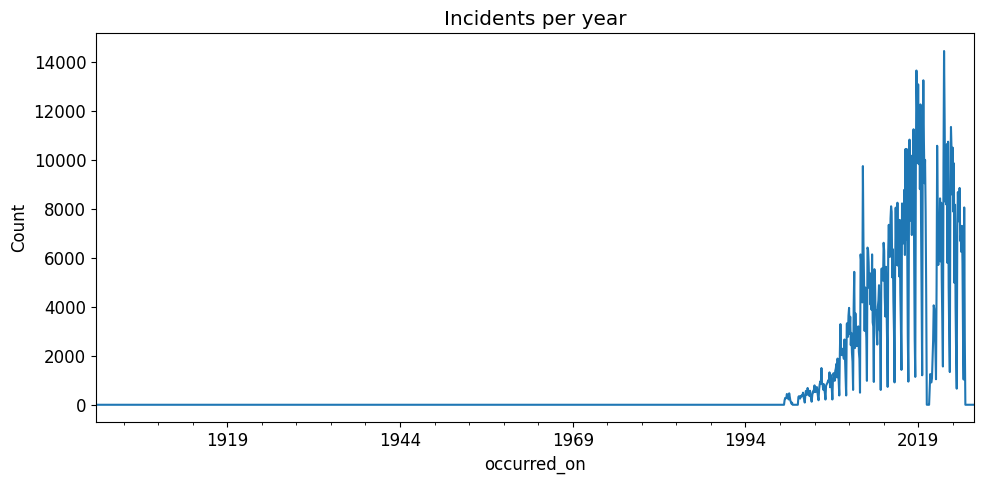

In [47]:
if 'occurred_on' in df.columns:
    monthly = df.set_index('occurred_on').resample('M').size()
    plt.figure()
    monthly.plot(title='Incidents per year')
    plt.ylabel('Count')
    plt.tight_layout()

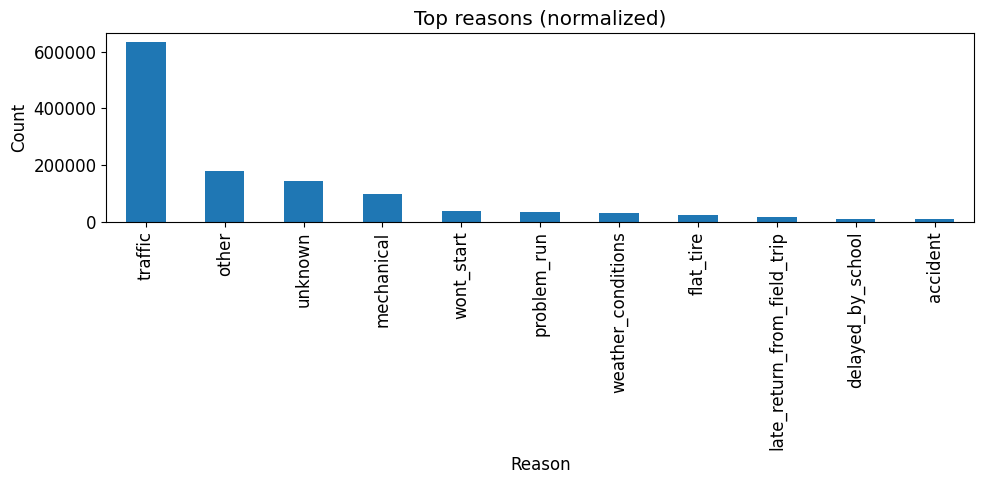

In [48]:
plt.figure()
df['reason_norm'].value_counts().head(20).plot(kind='bar')
plt.title('Top reasons (normalized)')
plt.xlabel('Reason')
plt.ylabel('Count')
plt.tight_layout()

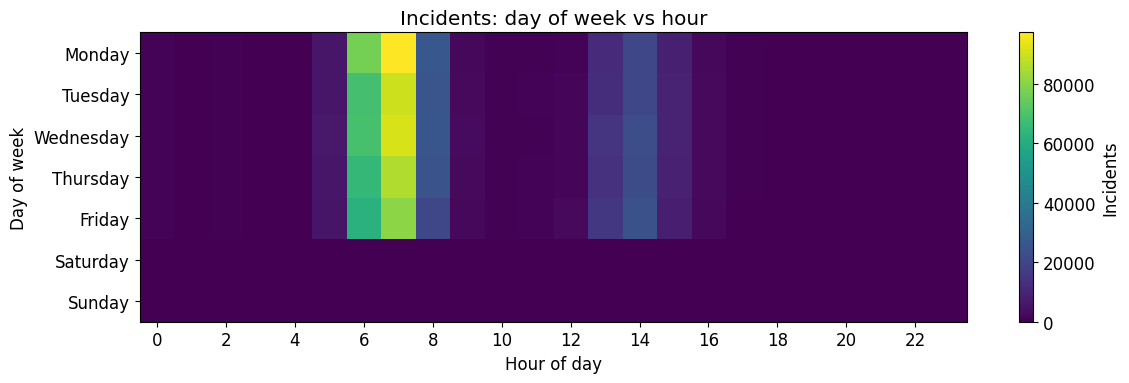

In [49]:
if 'hour' in df.columns and 'day_of_week' in df.columns:
    pivot = df.groupby(['day_of_week','hour']).size().unstack(fill_value=0)
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    pivot = pivot.reindex(days).fillna(0)
    plt.figure(figsize=(12,4))
    plt.imshow(pivot, aspect='auto')
    plt.colorbar(label='Incidents')
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(0,24,2), range(0,24,2))
    plt.title('Incidents: day of week vs hour')
    plt.xlabel('Hour of day')
    plt.ylabel('Day of week')
    plt.tight_layout()

In [90]:
if 'route_number' in df.columns:
    route_stats = df.groupby('route_number').agg(
        incidents=('route_number', 'size'),
        avg_delay=('delay_minutes', 'mean'),
    ).sort_values('incidents', ascending=False)
    print('Top routes by incidents:')
    print(route_stats.head(20))

Top routes by incidents:
              incidents  avg_delay
route_number                      
1                  7608  25.311889
2                  6898  24.709441
3                  4901  24.459220
5                  4180  24.491194
4                  3114  23.026884
6                  2188  25.801509
7                  1782  23.068366
8                  1542  26.468414
9                   782  22.777036
K001                683  51.949675
K005                678  31.748800
K011                675  34.893651
M604                673  45.015504
K016                669  31.240323
K013                669  30.116535
M978                664  40.533230
K017                664  33.206376
M605                648  47.147300
K100                645  61.949580
K080                628  32.689003


In [51]:
if 'bus_company_name' in df.columns:
    comp_stats = df.groupby('bus_company_name').agg(
        incidents=('bus_company_name', 'size'),
        avg_delay=('delay_minutes', 'mean')
    ).sort_values('incidents', ascending=False)
    print('\nTop companies by incidents:')
    print(comp_stats.head(20))


Top companies by incidents:
                                     incidents  avg_delay
bus_company_name                                         
AMBOY BUS COMPANY, INC                  104119  62.464406
LEESEL TRANSPORTATION CORP (B2192)       86705  50.187662
PIONEER TRANSPORTATION CORP              60272  34.793081
PRIDE TRANSPORTATION (SCH AGE)           58595  78.161598
BORO TRANSIT, INC.                       53061  41.163725
G.V.C., LTD.                             49360  25.809660
HOYT TRANSPORTATION CORP.                46656  32.487410
LITTLE RICHIE BUS SERVICE                41493  46.972887
ALLIED TRANSIT CORP.                     33581  30.508412
LOGAN BUS COMPANY INC.                   33203  48.358355
PIONEER TRANSPORTATION CO                29109  21.893960
L & M BUS CORP.                          27325  45.653946
VAN TRANS LLC (B2192)                    25552  28.603395
EMPIRE STATE BUS CORP.                   25531  29.346752
RELIANT TRANSPORTATION, INC (B2321)      23

In [52]:
if 'breakdown_or_running_late' in df.columns:
    df['target_breakdown'] = df['breakdown_or_running_late'].str.lower().map(lambda x: 1 if str(x).strip()== 'breakdown' else 0)
else:
    df['target_breakdown'] = np.nan

In [53]:
feature_cols = []
if 'hour' in df.columns:
    feature_cols.append('hour')
if 'month' in df.columns:
    feature_cols.append('month')
if 'is_weekend' in df.columns:
    feature_cols.append('is_weekend')
if 'number_of_students_on_the_bus' in df.columns:
    feature_cols.append('number_of_students_on_the_bus')

In [54]:
cat_cols = []
for c in ['run_type','boro','bus_company_name','route_number','school_age_or_prek','reason_norm','day_of_week']:
    if c in df.columns or c=='reason_norm' or c=='day_of_week':
        cat_cols.append(c)
        feature_cols.append(c)

print('Feature columns:', feature_cols)

Feature columns: ['hour', 'month', 'is_weekend', 'number_of_students_on_the_bus', 'run_type', 'boro', 'bus_company_name', 'route_number', 'school_age_or_prek', 'reason_norm', 'day_of_week']


In [55]:
if 'route_number' in df.columns and 'occurred_on' in df.columns:
    df_sorted = df.sort_values('occurred_on')
    route_counts = df_sorted.groupby('route_number').size().rename('route_total_incidents')
    df = df.merge(route_counts, how='left', left_on='route_number', right_index=True)
    feature_cols.append('route_total_incidents')

In [56]:
if 'bus_company_name' in df.columns:
    comp_counts = df.groupby('bus_company_name').size().rename('company_total_incidents')
    df = df.merge(comp_counts, how='left', left_on='bus_company_name', right_index=True)
    feature_cols.append('company_total_incidents')

In [57]:
model_df = df.copy()
model_df = model_df[model_df['target_breakdown'].notna()].reset_index(drop=True)
print('Rows for modeling (with target):', len(model_df))

Rows for modeling (with target): 1218709


In [60]:
X = model_df[feature_cols].copy()
y = model_df['target_breakdown'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Train/test sizes:', X_train.shape, X_test.shape)

Train/test sizes: (974967, 13) (243742, 13)


In [62]:
numeric_feats = [c for c in feature_cols if X_train[c].dtype.kind in 'biufc']
cat_feats = [c for c in feature_cols if c not in numeric_feats]

numeric_feats, cat_feats

(['hour',
  'month',
  'is_weekend',
  'number_of_students_on_the_bus',
  'route_total_incidents',
  'company_total_incidents'],
 ['run_type',
  'boro',
  'bus_company_name',
  'route_number',
  'school_age_or_prek',
  'reason_norm',
  'day_of_week'])

In [67]:
numeric_transformer = SimpleImputer(strategy='median')
cat_transformer = Pipeline(steps=[('impute', SimpleImputer(strategy='constant', fill_value='NA')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [69]:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_feats),('cat', cat_transformer, cat_feats)])

In [70]:
clf = XGBClassifier(n_estimators=200, max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=42)
pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])

print('Fitting classifier...')
pipe.fit(X_train, y_train)

Fitting classifier...


C:\Users\saisi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:22:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
clf = XGBClassifier(n_estimators=200, max_depth=6, use_label_encoder=False, eval_metric='logloss', random_state=42)
pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])

print('Fitting classifier...')
pipe.fit(X_train, y_train)

Fitting classifier...


C:\Users\saisi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:22:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
cat_ohe = pipe.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_names = list(cat_ohe.get_feature_names_out(cat_feats))
feat_names = numeric_feats + cat_names
importances = pipe.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False).head(40)
print('\nTop model importances:')
print(imp_df)


Top model importances:
                                               feature  importance
22952                              reason_norm_traffic    0.222400
22954                   reason_norm_weather_conditions    0.097296
22951                          reason_norm_problem_run    0.095186
22948          reason_norm_late_return_from_field_trip    0.054724
22950                                reason_norm_other    0.027691
22946                    reason_norm_delayed_by_school    0.019160
488          bus_company_name_LITTLE LISA BUS CO. INC.    0.017351
634       bus_company_name_PIONEER TRANSPORTATION CORP    0.015037
10                                   run_type_Pre-K/EI    0.014196
22947                            reason_norm_flat_tire    0.012086
699                       bus_company_name_SNT BUS INC    0.011799
22955                           reason_norm_wont_start    0.010933
403           bus_company_name_GRANDPA`S BUS CO., INC.    0.010044
258                bus_company_name_BO

In [75]:
reg_df = model_df[model_df['delay_minutes'].notna()].copy()
print('Rows available for regression (delay_minutes known):', len(reg_df))

Rows available for regression (delay_minutes known): 1040720


In [77]:
if len(reg_df) > 50:
    Xr = reg_df[feature_cols].copy()
    yr = reg_df['delay_minutes'].astype(float)
    Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=42)
    
    
    reg = XGBRegressor(n_estimators=200, max_depth=6, random_state=42)
    reg_pipe = Pipeline([('pre', preprocessor), ('reg', reg)])
    print('Fitting regressor...')
    reg_pipe.fit(Xr_train, yr_train)
    preds_r = reg_pipe.predict(Xr_test)
    print('MAE:', mean_absolute_error(yr_test, preds_r))
    print('RMSE:', math.sqrt(mean_squared_error(yr_test, preds_r)))
else:
    print('Not enough rows with delay_minutes for regression; consider cleaning more delay text or imputing.')

Fitting regressor...
MAE: 22.812575161519415
RMSE: 2498.204545075472


In [78]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []
for train_idx, val_idx in skf.split(X, y):
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    val_probs = pipe.predict_proba(X.iloc[val_idx])[:,1]
    aucs.append(roc_auc_score(y.iloc[val_idx], val_probs))

print('CV AUCs:', aucs, 'mean:', np.mean(aucs))

C:\Users\saisi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:24:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saisi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:25:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saisi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:25:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\saisi\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:25:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.

CV AUCs: [0.9644063917515958, 0.9645348996631644, 0.9649148381737813, 0.9645424849123556, 0.9647081589781636] mean: 0.9646213546958122


In [79]:
probs_val = pipe.predict_proba(X_test)[:,1]
best_thr, best_f1 = 0.5, 0
from sklearn.metrics import f1_score
for thr in np.linspace(0.1,0.9,41):
    f1 = f1_score(y_test, (probs_val>=thr).astype(int))
    if f1>best_f1:
        best_f1 = f1; best_thr = thr
print('Best validation F1:', best_f1, 'at threshold', best_thr)

Best validation F1: 0.7453758949880668 at threshold 0.38


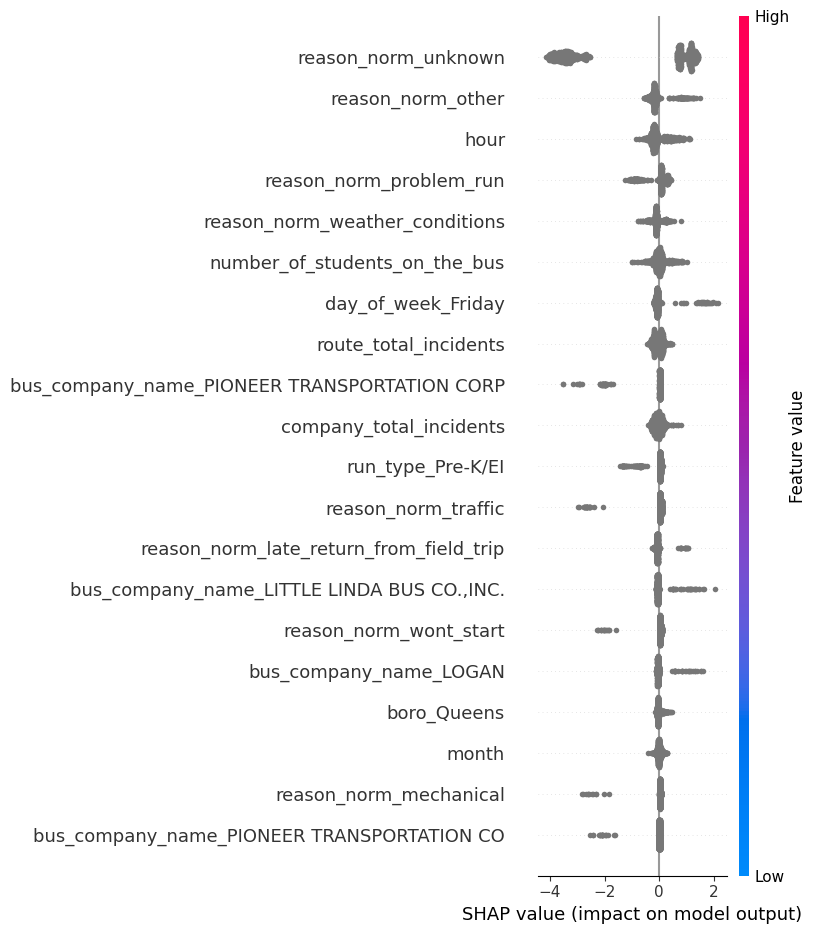

In [80]:
if 'shap' in globals():
    X_sample = X_test.sample(min(len(X_test), 1000), random_state=42)
    X_trans = pipe.named_steps['pre'].transform(X_sample)
    explainer = shap.TreeExplainer(pipe.named_steps['clf'])
    shap_values = explainer.shap_values(X_trans)
    shap.summary_plot(shap_values, X_trans, feature_names=feat_names)
else:
    print('SHAP not available — install shap to run this cell')

In [82]:
try:
    import joblib
    os.makedirs('models', exist_ok=True)
    joblib.dump(pipe, 'models/breakdown_classifier_pipeline.pkl')
    print('Saved classifier pipeline to models/breakdown_classifier_pipeline.pkl')
    if 'reg_pipe' in globals():
        joblib.dump(reg_pipe, 'models/delay_regressor_pipeline.pkl')
        print('Saved regressor pipeline to models/delay_regressor_pipeline.pkl')
except Exception as e:
    print('Joblib save failed — install joblib or check permissions:', e)

Saved classifier pipeline to models/breakdown_classifier_pipeline.pkl
Saved regressor pipeline to models/delay_regressor_pipeline.pkl


In [83]:
full_feats = model_df[feature_cols]
probs_all = pipe.predict_proba(full_feats)[:,1]
model_df['pred_prob_breakdown'] = probs_all
risk_list = model_df.sort_values('pred_prob_breakdown', ascending=False).head(200)
print('Top 10 predicted high-risk incidents (show columns):')
print(risk_list[['occurred_on','route_number','bus_no','bus_company_name','pred_prob_breakdown']].head(10))

Top 10 predicted high-risk incidents (show columns):
               occurred_on route_number bus_no          bus_company_name  \
286403 2012-12-20 03:09:00         Q008   3384    LOGAN BUS COMPANY INC.   
15016  2000-08-10 00:00:00         M410   1761                       NaN   
329670 2013-12-04 04:15:00        Q9057    364    LOGAN BUS COMPANY INC.   
309892 2013-07-15 02:27:00         Q354  5715D    LOGAN BUS COMPANY INC.   
288096 2013-01-08 03:00:00         Q007   3322    LOGAN BUS COMPANY INC.   
365386 2014-07-09 15:10:00         P283  5514D         LORINDA ENT. LTD.   
947523 2022-06-06 15:30:00         X589   570D  LITTLE LISA BUS CO. INC.   
216144 2011-12-13 15:18:00         X729  1489D  LITTLE LISA BUS CO. INC.   
582927 2017-06-27 15:25:00         X912  1423D  LITTLE LISA BUS CO. INC.   
372992 2014-09-23 15:07:00         X760   519D  LITTLE LISA BUS CO. INC.   

        pred_prob_breakdown  
286403             0.995629  
15016              0.995355  
329670             0

In [84]:
df.head()

,school_year,busbreakdown_id,run_type,bus_no,route_number,reason,schools_serviced,occurred_on,created_on,boro,...,delay_minutes,hour,date,day_of_week,month,year,is_weekend,target_breakdown,route_total_incidents,company_total_incidents
0,2015-2016,1272996,Special Ed AM Run,2256,K355,Won`t Start,15879.0,2016-06-03 06:03:00,2016-06-03 06:05:00,Brooklyn,...,NaN,6.0,2016-06-03,Friday,6.0,2016.0,False,1,104.0,19457.0
1,2016-2017,1313907,Special Ed AM Run,4481,K002,Won`t Start,22001.0,2017-01-10 05:55:00,2017-01-10 05:57:00,Brooklyn,...,30.0,5.0,2017-01-10,Tuesday,1.0,2017.0,False,0,502.0,13392.0
2,2015-2016,1267391,Special Ed AM Run,GT2114,Y925,Won`t Start,11012.0,2016-05-11 05:50:00,2016-05-11 05:59:00,Bronx,...,30.0,5.0,2016-05-11,Wednesday,5.0,2016.0,False,0,149.0,4650.0
3,2016-2017,1312240,General Ed AM Run,2436,K1546,Other,15032.0,2017-01-05 06:00:00,2017-01-05 06:05:00,Brooklyn,...,20.0,6.0,2017-01-05,Thursday,1.0,2017.0,False,0,51.0,6014.0
4,2016-2017,1312351,Special Ed AM Run,5814D,X441,Mechanical Problem,11002.0,2017-01-05 06:45:00,2017-01-05 06:54:00,Bronx,...,NaN,6.0,2017-01-05,Thursday,1.0,2017.0,False,1,50.0,6618.0


In [86]:
df.columns

Index(['school_year', 'busbreakdown_id', 'run_type', 'bus_no', 'route_number',
       'reason', 'schools_serviced', 'occurred_on', 'created_on', 'boro',
       'bus_company_name', 'how_long_delayed', 'number_of_students_on_the_bus',
       'has_contractor_notified_schools', 'has_contractor_notified_parents',
       'have_you_alerted_opt', 'informed_on', 'incident_number',
       'last_updated_on', 'breakdown_or_running_late', 'school_age_or_prek',
       'reason_norm', 'delay_minutes', 'hour', 'date', 'day_of_week', 'month',
       'year', 'is_weekend', 'target_breakdown', 'route_total_incidents',
       'company_total_incidents'],
      dtype='object')